In [1]:
!pip install vectorizers python-dotenv fast_hdbscan anthropic

In [2]:
%%bash
mamba install -c conda-forge numba cudatoolkit scikit-learn umap-learn matplotlib scipy pandas sentence-transformers datamapplot tqdm colorcet dask ipympl

conda-forge/linux-64                                        Using cache
conda-forge/noarch                                          Using cache
Transaction

  Prefix: /home/taylor/miniforge3/envs/kom

  All requested packages already installed


Looking for: ['numba', 'cudatoolkit', 'scikit-learn', 'umap-learn', 'matplotlib', 'scipy', 'pandas', 'sentence-transformers', 'datamapplot', 'tqdm', 'colorcet', 'dask', 'ipympl']


Pinned packages:
  - python 3.11.*




In [3]:
from dotenv import load_dotenv
import os

import numpy as np
import pandas as pd
# import datasets
import fast_hdbscan
import umap
import numba
import matplotlib.pyplot as plt

import sklearn .metrics
import vectorizers
import vectorizers.transformers
import sklearn.feature_extraction
import scipy.sparse

import sentence_transformers

from sklearn.utils.extmath import randomized_svd
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

import datamapplot
import colorcet as cc
import matplotlib

import tqdm
import string
# from llama_cpp import Llama

In [4]:
# Get an API key from Anthropic AI and put it in a .env file in this directory.
# e.g.
# ANTHROPIC_API_KEY="sk-an...
load_dotenv()

True

# Building a map and clusters

In [5]:
embedding_model = sentence_transformers.SentenceTransformer("all-mpnet-base-v2", device="cuda")

/home/taylor/miniforge3/envs/kom/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [6]:
dataset = pd.read_excel("./Topic_Results.xlsx", keep_default_na=False, na_values=[''])
# Cluster only the "Unlabbeled items"
dataset = dataset[dataset["Topic"] == "Unlabelled"]
# dataset.drop_duplicates(subset=["Title"], inplace=True)
# dataset = dataset[~(dataset["Manual Labelling"] == "N/A")]
# dataset = dataset[(dataset["Unnamed: 41"] == "AI")]
# dataset.reset_index(inplace=True)
dataset
# dataset.head()

,Title,Abstract,Topic,MetaTopic,embedding_alpha,embedding_beta,Manual Labelling Cleaned
0,2023 5th International Conference on Environme...,The proceedings contain 118 papers. The topics...,Unlabelled,Unlabelled,5.609941,1.297752,"Ocean Chemistry Detection, Contaminated Ocean ..."
6,A Biologist’s Guide to the Galaxy: Leveraging ...,Monitoring marine mammals is of broad interest...,Unlabelled,Marine Imagery Analysis,8.940141,0.134791,Biodiversity Monitoring
16,"A Global, Cross-System Meta-Analysis of Polych...",Studies evaluating the mechanisms underpinning...,Unlabelled,Unlabelled,6.168812,1.496978,Contaminated Ocean Water Detection
22,A Novel Framework to Predict Relative Habitat ...,Resource selection functions (RSFs) have been ...,Unlabelled,Unlabelled,9.087857,2.448749,Species Distribution
25,A Reproducible and Reusable Pipeline for Segme...,Segmentation of Earth science imagery is an in...,Unlabelled,Marine Imagery Analysis,7.681650,0.655072,Sea Floor Mapping And Bathymetry
...,...,...,...,...,...,...,...
871,Variability of Pacific herring (Clupea pallasi...,Pacific herring (Clupea pallasii) is an ecolog...,Unlabelled,Unlabelled,8.544971,3.182394,Species Distribution
872,Verification of the skill of numerical weather...,The goal of this study is the evaluation of th...,Unlabelled,Coastal Hazards And Modeling,1.808046,1.139072,Natural Disaster Forecasting
873,Versatile in silico modeling of partition coef...,"Environmental fate, behavior and effects of ha...",Unlabelled,Oil Spill Detection,5.884678,1.030208,Ocean Chemistry Detection
881,Wave field predictions using a multi-layer per...,"In this study, a novel data-driven model is pr...",Unlabelled,Coastal Hazards And Modeling,2.814817,-0.065330,Natural Disaster Forecasting


In [18]:
data_strings = dataset[["Title", "Abstract"]]

In [19]:
data_vectors = embedding_model.encode([v for k, v in (data_strings.Title + "\n\n" + data_strings.Abstract).items()], show_progress_bar=True)

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

In [20]:
data_map = umap.UMAP(metric="cosine", n_components=2, random_state=42).fit_transform(data_vectors)

/home/taylor/miniforge3/envs/kom/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


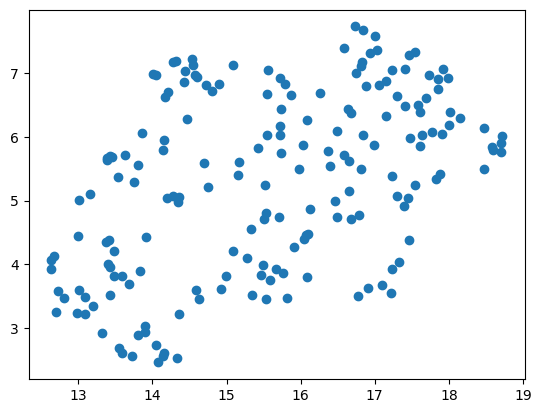

In [21]:
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(*data_map.T)
plt.show()

Now we need to do some clustering; for this I'll use HDBCSAN (more specifically fast_hdbscan seeing as it is faster and more flexible at reaching into some of the internals). I want layers of clusters not a strict hierarchy, so we'll use some HDBSCAN based tricks to make that possible. I also want to keep track of a bunch of information which will then be used to feed back into the cluster naming -- the cluster centroid in the map layout; the cluster centroid in the original high-d embedding space; what the subclusters are; and the actual data points in each cluster.

After that we'll throw together some quick functions to get topical and distinctive sentences and extract keywords.

In [22]:
@numba.njit(fastmath=True)
def layer_from_clustering(
    point_vectors,
    point_locations,
    cluster_label_vector,
    cluster_membership_vector,
    base_clusters,
    membership_strength_threshold=0.2,
):
    n_clusters = len(set(cluster_label_vector)) - 1
    
    average_vectors = np.zeros((n_clusters, point_vectors.shape[1]), dtype=np.float32)
    average_locations = np.zeros((n_clusters, point_locations.shape[1]), dtype=np.float32)
    total_weights = np.zeros(n_clusters, dtype=np.float32)
    pointsets = [set([-1 for i in range(0)]) for i in range(n_clusters)]
    metaclusters = [set([-1 for i in range(0)]) for i in range(n_clusters)]

    for i in range(cluster_label_vector.shape[0]):
        cluster_num = cluster_label_vector[i]
        if cluster_num >= 0:
            average_vectors[cluster_num] += cluster_membership_vector[i] * point_vectors[i]
            average_locations[cluster_num] += cluster_membership_vector[i] * point_locations[i]
            total_weights[cluster_num] += cluster_membership_vector[i]
            
            if cluster_membership_vector[i] > membership_strength_threshold:
                pointsets[cluster_num].add(i)
                sub_cluster = base_clusters[i]
                if sub_cluster != -1:
                    metaclusters[cluster_num].add(sub_cluster)
                
    for c in range(n_clusters):
        average_vectors[c] /= total_weights[c]
        average_locations[c] /= total_weights[c]
        
    return average_vectors, average_locations, pointsets, metaclusters
                
            
def build_cluster_layers(
    point_vectors,
    point_locations,
    *,
    min_clusters=2,
    min_samples=5,
    base_min_cluster_size=10,
    membership_strength_threshold=0.2,
    next_cluster_size_quantile=0.8,
):
    vector_layers = []
    location_layers = []
    pointset_layers = []
    metacluster_layers = []
    
    min_cluster_size = base_min_cluster_size
    
    sklearn_tree = fast_hdbscan.hdbscan.KDTree(point_locations)
    numba_tree = fast_hdbscan.numba_kdtree.kdtree_to_numba(sklearn_tree)
    edges = fast_hdbscan.boruvka.parallel_boruvka(
        numba_tree, min_samples=min_cluster_size if min_samples is None else min_samples
    )
    sorted_mst = edges[np.argsort(edges.T[2])]
    uncondensed_tree = fast_hdbscan.cluster_trees.mst_to_linkage_tree(sorted_mst)
    new_tree = fast_hdbscan.cluster_trees.condense_tree(uncondensed_tree, base_min_cluster_size)
    leaves = fast_hdbscan.cluster_trees.extract_leaves(new_tree)
    clusters = fast_hdbscan.cluster_trees.get_cluster_label_vector(new_tree, leaves, 0.0)
    point_probs = fast_hdbscan.cluster_trees.get_point_membership_strength_vector(new_tree, leaves, clusters)


    cluster_ids = np.unique(clusters[clusters >= 0])
    base_clusters = clusters.copy()
    n_clusters_in_layer = cluster_ids.shape[0]
    
    base_layer = True

    while n_clusters_in_layer >= min_clusters:
        layer_vectors, layer_locations, layer_pointsets, layer_metaclusters = layer_from_clustering(
            point_vectors,
            point_locations,
            clusters,
            point_probs,
            base_clusters,
            membership_strength_threshold,            
        )
            
        if not base_layer:
            layer_metacluster_selection = np.asarray([len(x) > 1 for x in layer_metaclusters])
            layer_metaclusters = [
                list(x) for x, select in zip(layer_metaclusters, layer_metacluster_selection) if select
            ]
            layer_pointsets = [
                list(x) for x, select in zip(layer_pointsets, layer_metacluster_selection) if select
            ]
            layer_vectors = layer_vectors[layer_metacluster_selection]
            layer_locations=  layer_locations[layer_metacluster_selection]
            
        vector_layers.append(layer_vectors)
        location_layers.append(layer_locations)
        pointset_layers.append(layer_pointsets)
        metacluster_layers.append(layer_metaclusters)
        
        last_min_cluster_size = min_cluster_size
        min_cluster_size = int(np.quantile([len(x) for x in layer_pointsets], next_cluster_size_quantile))
        print(len(layer_vectors), last_min_cluster_size, min_cluster_size)
        
        new_tree = fast_hdbscan.cluster_trees.condense_tree(uncondensed_tree, min_cluster_size)
        leaves = fast_hdbscan.cluster_trees.extract_leaves(new_tree)
        clusters = fast_hdbscan.cluster_trees.get_cluster_label_vector(new_tree, leaves, 0.0)
        point_probs = fast_hdbscan.cluster_trees.get_point_membership_strength_vector(new_tree, leaves, clusters)
        
        cluster_ids = np.unique(clusters[clusters >= 0])
        n_clusters_in_layer = np.max(clusters) + 1
        base_layer = False
       
    pointset_layers = [[list(pointset) for pointset in layer] for layer in pointset_layers]
    return vector_layers, location_layers, pointset_layers, metacluster_layers


def diversify(query_vector, candidate_neighbor_vectors, alpha=1.0, max_candidates=16):
    distance_to_query = np.squeeze(sklearn.metrics.pairwise_distances(
        [query_vector], candidate_neighbor_vectors, metric="cosine")
    )
                                   
    retained_neighbor_indices = [0]
    for i, vector in enumerate(candidate_neighbor_vectors[1:], 1):
        retained_neighbor_distances = sklearn.metrics.pairwise_distances(
            [vector], candidate_neighbor_vectors[retained_neighbor_indices], metric="cosine"
        )[0]
        for j in range(retained_neighbor_distances.shape[0]):
            if alpha * distance_to_query[i] > retained_neighbor_distances[j]:
                break
        else:
            retained_neighbor_indices.append(i)
            if len(retained_neighbor_indices) >= max_candidates:
                return retained_neighbor_indices
            
    return retained_neighbor_indices


def topical_sentences_for_cluster(docs, vector_array, pointset, centroid_vector, n_sentence_examples=16):
    sentences = docs.values[pointset]

    sent_vectors = vector_array[pointset]
    candidate_neighbor_indices = np.argsort(
        np.squeeze(sklearn.metrics.pairwise_distances([centroid_vector], sent_vectors, metric="cosine"))
    )
    candidate_neighbors = sent_vectors[candidate_neighbor_indices]
    topical_sentence_indices = candidate_neighbor_indices[
        diversify(centroid_vector, candidate_neighbors)[:n_sentence_examples]
    ]
    topical_sentences = [sentences[i] for i in topical_sentence_indices]
    return topical_sentences

def distinctive_sentences_for_cluster(
    cluster_num, docs, vector_array, pointset_layer, cluster_neighbors, n_sentence_examples=16
):
    pointset = pointset_layer[cluster_num]
    sentences = docs.values[pointset]

    local_vectors = vector_array[sum([pointset_layer[x] for x in cluster_neighbors], [])]
    vectors_for_svd = normalize(local_vectors - local_vectors.mean(axis=0))
    U, S, Vh = randomized_svd(vectors_for_svd, 64)
    transformed_docs = (local_vectors @ Vh.T)
    transformed_docs = np.where(transformed_docs > 0, transformed_docs, 0)
    class_labels = np.repeat(
        np.arange(
            len(cluster_neighbors)
        ), 
        [len(pointset_layer[x]) for x in cluster_neighbors]
    )
    iwt = vectorizers.transformers.InformationWeightTransformer().fit(transformed_docs, class_labels)
    sentence_weights = np.sum(transformed_docs[:len(pointset)] * iwt.information_weights_, axis=1)
    distinctive_sentence_indices = np.argsort(sentence_weights)[:n_sentence_examples * 3]
    distinctive_sentence_vectors = vector_array[distinctive_sentence_indices]
    diversified_candidates = diversify(
        vector_array[pointset_layer[cluster_num]].mean(axis=0), 
        distinctive_sentence_vectors
    )
    distinctive_sentence_indices = distinctive_sentence_indices[diversified_candidates[:n_sentence_examples]]
    distinctive_sentences = [sentences[i] for i in distinctive_sentence_indices]
    return distinctive_sentences

def longest_keyphrases(candidate_keyphrases):
    result = []
    for i, phrase in enumerate(candidate_keyphrases):
        for other in candidate_keyphrases:
            if f" {phrase}" in other or f"{phrase} " in other:
                phrase = other
                
        if phrase not in result:
            candidate_keyphrases[i] = phrase
            result.append(phrase)
            
    return result

def contrastive_keywords_for_layer(
    full_count_matrix, 
    inverse_vocab, 
    pointset_layer, 
    doc_vectors, 
    vocab_vectors, 
    n_keywords=16, 
    prior_strength=0.1,
    weight_power=2.0
):
    count_matrix = full_count_matrix[sum(pointset_layer, []), :]
    column_mask = np.squeeze(np.asarray(count_matrix.sum(axis=0))) > 0.0
    count_matrix = count_matrix[:, column_mask]
    column_map = np.arange(full_count_matrix.shape[1])[column_mask]
    
    class_labels = np.repeat(np.arange(len(pointset_layer)), [len(x) for x in pointset_layer])
    iwt = vectorizers.transformers.InformationWeightTransformer(
        prior_strength=prior_strength, weight_power=weight_power
    ).fit(
        count_matrix, class_labels
    )
    count_matrix.data = np.log(count_matrix.data + 1)
    count_matrix.eliminate_zeros()
    
    weighted_matrix = iwt.transform(count_matrix)
    
    contrastive_keyword_layer = []
    
    from_row = 0
    for i in range(len(pointset_layer)):
        to_row = from_row + len(pointset_layer[i])
        contrastive_scores = np.squeeze(np.asarray(weighted_matrix[from_row:to_row].sum(axis=0)))
        contrastive_keyword_indices = np.argsort(contrastive_scores)[-4 * n_keywords:]
        contrastive_keywords = [inverse_vocab[column_map[j]] for j in reversed(contrastive_keyword_indices)]
        contrastive_keywords = longest_keyphrases(contrastive_keywords)
        
        centroid_vector = np.mean(doc_vectors[pointset_layer[i]], axis=0)
        keyword_vectors = np.asarray([vocab_vectors[word] for word in contrastive_keywords])
        chosen_indices = diversify(centroid_vector, keyword_vectors, alpha=0.66)[:n_keywords]
        contrastive_keywords = [contrastive_keywords[j] for j in chosen_indices]
        
        contrastive_keyword_layer.append(contrastive_keywords)
        from_row = to_row
        
    return contrastive_keyword_layer

So now we just cluster, picking a minimim base cluster size and let the choices of layering from there be decided by the algorithm. This does not take long.

# Clustering metrics

In [25]:
from tqdm.auto import trange

scs = []
chs = []
dbs = []
pos = []
nclust = []

for min_cluster_size in trange(2, 15):
    vector_layers, location_layers, pointset_layers, metacluster_layers = build_cluster_layers(
        data_vectors, data_map, base_min_cluster_size=min_cluster_size, min_clusters=4,
    )

    # ToDo: Drop outlier classes?
    int_labels = [-1] * len(data_vectors)
    for int_label, a in enumerate(pointset_layers[0]):
        for i in a:
            int_labels[i] = int_label

    # percent outliers
    int_labels = np.array(int_labels)
    inlier = int_labels >= 0
    outlier = int_labels == -1
    pos.append(sum(outlier)/len(int_labels))

    scs.append(silhouette_score(data_vectors[inlier], int_labels[inlier]))
    chs.append(calinski_harabasz_score(data_vectors[inlier], int_labels[inlier]))
    dbs.append(davies_bouldin_score(data_vectors[inlier], int_labels[inlier]))
    nclust.append(len(metacluster_layers[0]))

  0%|          | 0/13 [00:00<?, ?it/s]

18 2 8
3 8 31
13 3 11
3 11 36
12 4 12
3 12 36
9 5 20
8 6 20
8 7 20
7 8 21
7 9 21
6 10 36
5 11 36
5 12 36
4 13 36
4 14 36


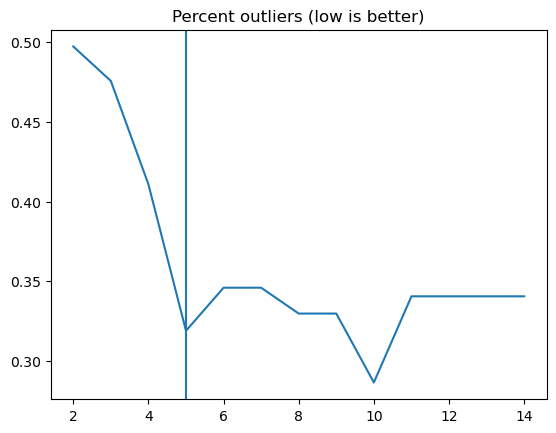

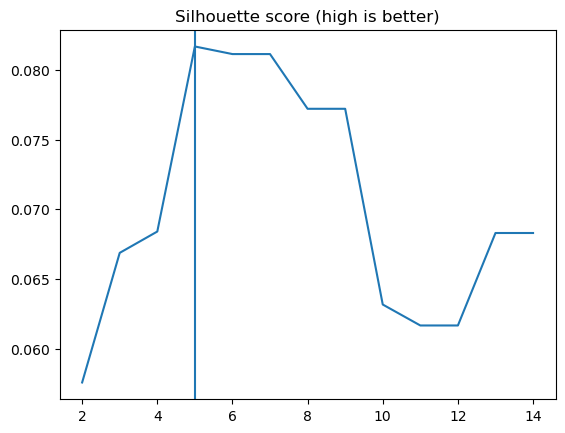

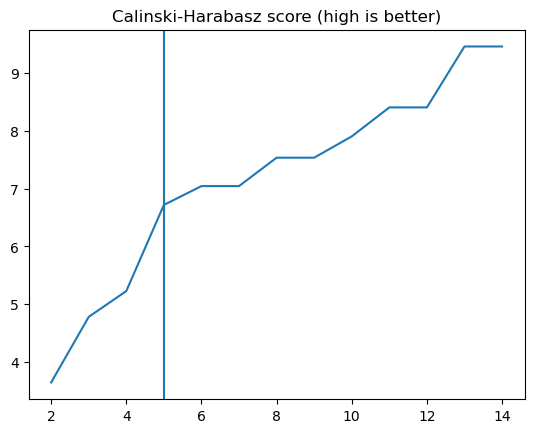

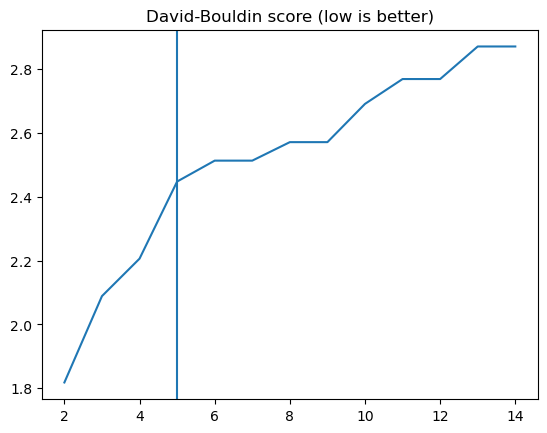

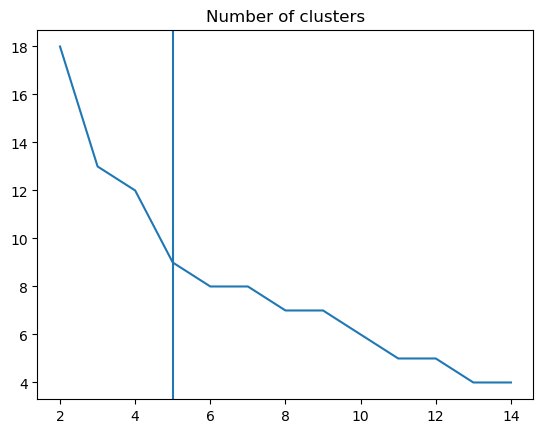

In [29]:
min_cluster_size = 5

plt.figure()
plt.plot(list(range(2, 15)), pos)
plt.axvline(min_cluster_size)
plt.title("Percent outliers (low is better)")
plt.show()

plt.figure()
plt.plot(list(range(2, 15)), scs)
plt.axvline(min_cluster_size)
plt.title("Silhouette score (high is better)")
plt.show()

plt.figure()
plt.plot(list(range(2, 15)), chs)
plt.axvline(min_cluster_size)
plt.title("Calinski-Harabasz score (high is better)")
plt.show()

plt.figure()
plt.plot(list(range(2, 15)), dbs)
plt.axvline(min_cluster_size)
plt.title("David-Bouldin score (low is better)")
plt.show()

plt.figure()
plt.plot(list(range(2, 15)), nclust)
plt.axvline(min_cluster_size)
plt.title("Number of clusters")
plt.show()

In [30]:
%%time
vector_layers, location_layers, pointset_layers, metacluster_layers = build_cluster_layers(
    data_vectors, data_map, base_min_cluster_size=min_cluster_size, min_clusters=3,
)
print(len(vector_layers[0]))

9 5 20
3 20 36
9
CPU times: user 12.2 ms, sys: 6.88 ms, total: 19.1 ms
Wall time: 10.3 ms


# Extracting useful cluster information for topic naming

Next I'm going to need a little more information, since for distinctive sentences (and later on as well) it will help to know what nearby clusters are. We could write something to do this efficiently, but there aren't that many clusters so we'll just brute-force the whole thing.

In [31]:
layer_cluster_neighbors = [
    np.argsort(
        sklearn.metrics.pairwise_distances(layer, metric="cosine"), 
        axis=1
    )[:, :16]
    for layer in vector_layers
]

Now we can generate topical sentences (sentences most similar to the cluster centroid, up to some diversification) and distinctive sentences (sentences that most strongly distinguish this cluster from nearby ones) for all the clusters.

In [32]:
%%time
topical_sentences_per_cluster = [
    [
        topical_sentences_for_cluster(data_strings["Title"], data_vectors, pointset, cluster_vector)
        for pointset, cluster_vector in zip(pointset_layers[i], vector_layers[i])
    ]
    for i in range(len(pointset_layers))
]

CPU times: user 45.8 ms, sys: 3.78 ms, total: 49.6 ms
Wall time: 48.2 ms


In [33]:
%%time
distinctive_sentences_per_cluster = [
    [
        distinctive_sentences_for_cluster(
            topic_num, data_strings["Title"], data_vectors, pointset_layers[i], layer_cluster_neighbors[i][topic_num]
        )
        for topic_num in range(len(pointset_layers[i]))
    ]
    for i in range(len(pointset_layers))
]

CPU times: user 790 ms, sys: 43 ms, total: 833 ms
Wall time: 833 ms


Next I'm going to want some keywords for each cluster. I'm just stealing from other similar code I wrote here, so please excuse the mess -- this was just a "get it done" effort. In essence this is really much the same as BERTopic's c-TF-IDF except it uses the slightly newer supervised information weighting instead c-IDF. It also helps to use a decent n-gram range and beef up the min_df to get more informative keywords.

In [34]:
%%time
cv = sklearn.feature_extraction.text.CountVectorizer(lowercase=True, min_df=25, token_pattern='(?u)\\b\\w[-\'\\w]+\\b', ngram_range=(1,4))
full_count_matrix = cv.fit_transform(data_strings["Title"] + " " + data_strings["Abstract"])
acceptable_vocab = [v for v in cv.vocabulary_ if v.split()[0] not in sklearn.feature_extraction.text.ENGLISH_STOP_WORDS and v.split()[-1] not in sklearn.feature_extraction.text.ENGLISH_STOP_WORDS]
acceptable_indices = [cv.vocabulary_[v] for v in acceptable_vocab]
full_count_matrix = full_count_matrix[:, acceptable_indices]
inverse_vocab = {i:w for i, w in enumerate(acceptable_vocab)}
vocab = acceptable_vocab
len(vocab)

CPU times: user 64.9 ms, sys: 12.1 ms, total: 77 ms
Wall time: 76.4 ms


100

In [35]:
vocab_vectors = dict(zip(vocab, embedding_model.encode(vocab, show_progress_bar=True)))

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

In [36]:
%%time
contrastive_keyword_layers = [
        contrastive_keywords_for_layer(
        full_count_matrix, 
        inverse_vocab, 
        pointset_layers[layer_num], 
        data_vectors,
        vocab_vectors,
    )
    for layer_num in range(len(pointset_layers))
]

CPU times: user 554 ms, sys: 67.9 ms, total: 622 ms
Wall time: 622 ms


# Naming the lowest layer of topics

Now we get to the point of using an LLM to create topic names. I went through a few iterations of things like this, and this is what the prompt generation evolved into; if I was starting from scratch I think we could write this much more cleanly. Still, it gets the job done.

In [37]:
def create_prompt(
    i, 
    contrastive_keyword_layer=contrastive_keyword_layers[0], 
    topical_sentences_per_cluster=topical_sentences_per_cluster[0],
    distinctive_sentences_per_cluster=distinctive_sentences_per_cluster[0],
    base_cluster_neighbors=layer_cluster_neighbors[0],
):
    prompt_text = "--\n\nBelow is a information about a group of titles from machine learning articles:\n\n"
    prompt_text += "Distinguishing keywords for this group:\n - \"" + ", ".join(contrastive_keyword_layer[i]) + "\"\n"
    prompt_text += "\nSample topical titles from the group include:\n"
    for text in topical_sentences_per_cluster[i]:
        prompt_text += f" - \"{text}\"\n"
    prompt_text += "\nSample distinctive titles from the group include:\n"
    for text in distinctive_sentences_per_cluster[i]:
        prompt_text += f" - \"{text}\"\n"

    prompt_text += "\n\nSimilar titles from different groups with distinct topics include:\n"
    for n in base_cluster_neighbors[i][:3]:
        for text in distinctive_sentences_per_cluster[n][:2]:
            prompt_text += f"- \"{text}\"\n"

    prompt_text += "\n\nThe short distinguishing topic name for the group that had the keywords:\n - \"" + ", ".join(contrastive_keyword_layer[i][:8]) + "\" \n"
    prompt_text += "is:\n"
    return prompt_text

In [38]:
import anthropic

client = anthropic.Anthropic()

# Duplicate Llama api for calling
def llm(prompt, max_tokens=16, temperature=0.8):
    message = client.messages.create(
        model="claude-3-opus-20240229",
        max_tokens=max_tokens,
        temperature=temperature,
        system="Give terse category names for the questions asked. Do not provide explanations for your responses." 
        "Make sure each topic name is sufficiently distinct from other topic groups."
        "All papers are, to some degree, about machine learning and oceanography, so using words like 'Machine Learning', 'Marine' may be redundant and should be mostly avoided.",
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": f"{prompt}"
                    }
                ]
            }
        ]
    )
    return message

Now we need out LLM. A quantized version of Mistral 7B is not bad, but pick the model that works for you. If you have a GPU this goes a lot faster. If you have a big GPU you will probably want a better model. In general the most powerful model that you can run on the hardware you have is likely your best bet.

In [39]:
# !wget https://huggingface.co/TheBloke/OpenHermes-2.5-Mistral-7B-GGUF/resolve/main/openhermes-2.5-mistral-7b.Q4_K_M.gguf
# !wget https://huggingface.co/QuantFactory/Meta-Llama-3-8B-Instruct-GGUF/resolve/main/Meta-Llama-3-8B-Instruct.Q4_K_M.gguf
# !wget https://huggingface.co/QuantFactory/Meta-Llama-3-70B-Instruct-GGUF/resolve/main/Meta-Llama-3-70B-Instruct.Q4_K_M.gguf

In [40]:
# llm = Llama(model_path="openhermes-2.5-mistral-7b.Q4_K_M.gguf", n_gpu_layers=-1, n_ctx=4096, stop=["--", "\n"], verbose=False)
# llm = Llama(model_path="Meta-Llama-3-8B-Instruct.Q4_K_M.gguf", n_gpu_layers=-1, n_ctx=4096, stop=["--", "\n"], verbose=False)
# llm = Llama(model_path="Meta-Llama-3-70B-Instruct.Q4_K_M.gguf", n_gpu_layers=-1, n_ctx=4096, stop=["--", "\n"], verbose=False)
# llm()

Before we run this in earnest let's try it out on the first cluster to make sure it works.

In [41]:
llm(create_prompt(0), max_tokens=24, temperature=0.75)

Message(id='msg_01J2KCXs8pWQq1tvWQJq1feZ', content=[TextBlock(text='Seafood Quality Detection', type='text')], model='claude-3-opus-20240229', role='assistant', stop_reason='end_turn', stop_sequence=None, type='message', usage=Usage(input_tokens=580, output_tokens=8))

Looks good enough. Obviously we'll need to clean up the output a little, but that's easy enough to add. Let's write a function to do the naming ...

In [42]:
def base_level_topic_names(
    topical_sentence_layer,
    distinctive_sentence_layer,
    contrastive_keyword_layer,
    base_cluster_neighbors,
    from_topic_index=0,
    to_topic_index=10,
):
    topic_names = []
    for i in tqdm.notebook.tqdm(range(from_topic_index, to_topic_index)):
        topic_naming_prompt = create_prompt(
            i, 
            contrastive_keyword_layer=contrastive_keyword_layer, 
            topical_sentences_per_cluster=topical_sentence_layer,
            distinctive_sentences_per_cluster=distinctive_sentence_layer,
            base_cluster_neighbors=base_cluster_neighbors,
        )
        topic_name = llm(topic_naming_prompt).content[0].text
        if "\n" in topic_name:
            topic_name = topic_name.lstrip("\n ")
            topic_name = topic_name.split("\n")[0]
        topic_name = string.capwords(topic_name.strip(string.punctuation + string.whitespace))
        topic_names.append(topic_name)

    return topic_names

And away we go ...



In [43]:
%%time
layer0_topics = base_level_topic_names(
    topical_sentences_per_cluster[0],
    distinctive_sentences_per_cluster[0],
    contrastive_keyword_layers[0],
    layer_cluster_neighbors[0],
    to_topic_index=len(contrastive_keyword_layers[0])
)

  0%|          | 0/9 [00:00<?, ?it/s]

CPU times: user 93.8 ms, sys: 8.99 ms, total: 103 ms
Wall time: 21.9 s


In [44]:
layer0_topics

['Seafood Quality Assessment',
 'Water Quality Prediction',
 'Water Pollution Modeling',
 'Coastal Forecasting Models',
 'Coastal Morphodynamic Modeling',
 'Environmental Modeling',
 'Coastal Remote Sensing',
 'Animal Behavior Classification',
 'Image Classification']

# Naming all the other layers of topics

Now we have the other layers to deal with. Since these are larger clusters it is harder to get representative sentences that cover the full breadth and still fit in the prompt context size. However we did keep track of sub-clusters and now we have names for all those sub-clusters, so we can provide that instead. Of course if there are too many sub-clusters that can be tricky as well. So pick out the topical sub-topic names and distinctive sub-topic names (with a large selection) -- we just need to embed all the cluster names we've got so far.

In [45]:
embeddings_of_layer0_topics = embedding_model.encode(layer0_topics, show_progress_bar=True)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [46]:
def topical_subtopics_for_cluster(
    metacluster, pointset, doc_vectors, base_layer_topic_names, base_layer_pointsets, n_subtopics=32
):
    centroid_vector = np.mean(doc_vectors[pointset], axis=0)
    subtopic_vectors = np.asarray([np.mean(doc_vectors[base_layer_pointsets[n]], axis=0) for n in metacluster])
    candidate_neighbor_indices = np.argsort(
        np.squeeze(sklearn.metrics.pairwise_distances([centroid_vector], subtopic_vectors, metric="cosine"))
    )[:2 * n_subtopics]
    candidate_neighbors = subtopic_vectors[candidate_neighbor_indices]
    topical_subtopic_indices = candidate_neighbor_indices[
        diversify(centroid_vector, candidate_neighbors, alpha=0.66, max_candidates=n_subtopics)
    ][:n_subtopics]
    topical_subtopics = [base_layer_topic_names[metacluster[i]] for i in topical_subtopic_indices]
    return topical_subtopics


def contrastive_subtopics_for_cluster(
    cluster_neighbors, meta_clusters, base_layer_topic_embeddings, base_layer_topic_names, n_subtopics=24
):
    topic_names = [base_layer_topic_names[x] for x in meta_clusters[cluster_neighbors[0]]]
    local_vectors = base_layer_topic_embeddings[sum([meta_clusters[x] for x in cluster_neighbors], [])]
    U, S, Vh = np.linalg.svd(local_vectors - local_vectors.mean(axis=0))
    transformed_docs = (local_vectors @ Vh.T)
    transformed_docs = np.where(transformed_docs > 0, transformed_docs, 0)
    class_labels = np.repeat(np.arange(len(cluster_neighbors)), [len(meta_clusters[x]) for x in cluster_neighbors])
    iwt = vectorizers.transformers.InformationWeightTransformer().fit(transformed_docs, class_labels)
    topic_name_weights = np.sum(transformed_docs[:len(topic_names)] * iwt.information_weights_, axis=1)
    distinctive_topic_indices = np.argsort(topic_name_weights)[:n_subtopics * 3]
    distinctive_topic_vectors = base_layer_topic_embeddings[distinctive_topic_indices]
    diversified_candidates = diversify(
        base_layer_topic_embeddings[meta_clusters[cluster_neighbors[0]]].mean(axis=0), 
        distinctive_topic_vectors
    )
    distinctive_topic_indices = distinctive_topic_indices[diversified_candidates[:n_subtopics]]
    distinctive_sentences = [topic_names[i] for i in distinctive_topic_indices]
    return distinctive_sentences

Now we just need to build that information for all the layers and clusters ...

In [47]:
%%time
topical_subtopic_layers = [
    [
        topical_subtopics_for_cluster(
            metacluster_layers[layer_num][cluster_num],
            pointset_layers[layer_num][cluster_num],
            data_vectors,
            layer0_topics,
            pointset_layers[0],
            n_subtopics=32
        )
        for cluster_num in range(len(metacluster_layers[layer_num]))
    ]
    for layer_num in range(1, len(metacluster_layers))
]

CPU times: user 10.3 ms, sys: 3.83 ms, total: 14.1 ms
Wall time: 12.6 ms


In [48]:
%%time
contrastive_subtopic_layers = [
    [
        contrastive_subtopics_for_cluster(
            layer_cluster_neighbors[layer_num][cluster_num],
            metacluster_layers[layer_num],
            embeddings_of_layer0_topics,
            layer0_topics,
            n_subtopics=24
        )
        for cluster_num in range(len(metacluster_layers[layer_num]))
    ]
    for layer_num in range(1, len(metacluster_layers))
]

CPU times: user 25.6 ms, sys: 4.17 ms, total: 29.8 ms
Wall time: 27.8 ms


/home/taylor/miniforge3/envs/kom/lib/python3.11/site-packages/vectorizers/transformers/info_weight.py:254: RuntimeWarning: invalid value encountered in power
  self.information_weights_ = np.power(


Given that we are using the sub-topic names we need a different prompt construction.

In [49]:
def create_prompt_from_subtopics(
    i,
    contrastive_keyword_layer,
    subtopic_layer,
    topical_sentences_layer,
    distinctive_sentences_layer,
    cluster_neighbors
):
    prompt_text = "--\n\nBelow is a information about a group of titles from machine learning articles that are all on the same topic:\n\n"
    prompt_text += "Distinguishing keywords for this group: \"" + ", ".join(contrastive_keyword_layer[i]) + "\"\n"
    prompt_text += "Sample sub-topics from the group include:\n"
    for text in subtopic_layer[i][:24]:
        prompt_text += f"- \"{text}\"\n"
    prompt_text += "Sample topical titles include:\n"
    for text in topical_sentences_layer[i][:4]:
        prompt_text += f"- \"{text}\"\n"
    prompt_text += "Sample distinctive titles of the topic include:\n"
    for text in distinctive_sentences_layer[i][:4]:
        prompt_text += f"- \"{text}\"\n"        
    

    prompt_text += "\n\nSimilar titles from different groups with distinct topics include:\n"
    for n in cluster_neighbors[i][:3]:
        for text in topical_sentences_layer[n][:2]:
            prompt_text += f"- \"{text}\"\n"
    prompt_text += "\nSub-topics from different but similar groups include:\n"
    for n in cluster_neighbors[i][:3]:
        for text in subtopic_layer[n][:4]:
            prompt_text += f"- \"{text}\"\n"    
            
    prompt_text += "\n\nThe short distinguishing topic name for the group that had the keywords \"" + ", ".join(contrastive_keyword_layer[i]) + "\" "
    prompt_text += "is:"
    return prompt_text

Then we just need a function for do all the naming and clean uip the output names ...

In [50]:
def subtopics_and_keywords_to_topic_name(
    subtopics_layer,
    contrastive_keyword_layer,
    topical_sentences_layer,
    distinctive_sentences_layer,
    cluster_neighbors,
    from_topic_index=0,
    to_topic_index=10,
):
    topic_names = []
    for i in tqdm.notebook.tqdm(range(from_topic_index, to_topic_index)):
        topic_naming_prompt = create_prompt_from_subtopics(
            i, 
            contrastive_keyword_layer, 
            subtopics_layer,
            topical_sentences_layer,
            distinctive_sentences_layer,
            cluster_neighbors,
        )
        topic_name = llm(topic_naming_prompt).content[0].text
        if "\n" in topic_name:
            topic_name = topic_name.lstrip("\n ")
            topic_name = topic_name.split("\n")[0]
        topic_name = string.capwords(topic_name.strip(string.punctuation + string.whitespace))

        topic_names.append(topic_name)

    return topic_names

And we can start naming topics for the other layers ...

In [51]:
%%time
layer_n_topics = [subtopics_and_keywords_to_topic_name(
    [a + b for a,b in zip(topical_subtopic_layers[i], contrastive_subtopic_layers[i])],
    contrastive_keyword_layers[i+1],
    topical_sentences_per_cluster[i+1],
    distinctive_sentences_per_cluster[i+1],
    layer_cluster_neighbors[i+1],
    from_topic_index=0,
    to_topic_index=len(topical_subtopic_layers[i]),
) for i in trange(len(topical_subtopic_layers))]

all_layer_topics = [layer0_topics, *layer_n_topics]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 35.6 ms, sys: 18.7 ms, total: 54.3 ms
Wall time: 5.83 s


The last problem that tends to occur is that we end up repeating topic names, particulary having high level topic names get repeated at lower levels where we want something more specific. But we can lookmfor those cases and try to get the LLM to generate a more specific topic name.

In [52]:
def create_final_remedy_prompt(original_topic_names, docs, vector_array, pointset, centroid_vector):
    sentences = topical_sentences_for_cluster(docs, vector_array, pointset, centroid_vector, n_sentence_examples=64)
    prompt_text = "A set of titles from machine learning articles was described as having a topic of one of " + ", ".join(original_topic_names) + ".\n"
    prompt_text += "These topic names were not specific enough and were shared with other different but similar groups of titles.\n"
    prompt_text += "A sampling of titles from this specific set of titles includes:\n"
    for sentence in np.random.choice(sentences, size=min(len(sentences), 64), replace=False):
        prompt_text += f"- {sentence}\n"

    prompt_text += f"\n\nThe current name for this topic of these paragraphs is: {original_topic_names[-1]}\n"
    prompt_text += "A better and more specific name that still captures the topic of these article titles is: "
    return prompt_text

In [53]:
all_layer_topics

[['Seafood Quality Assessment',
  'Water Quality Prediction',
  'Water Pollution Modeling',
  'Coastal Forecasting Models',
  'Coastal Morphodynamic Modeling',
  'Environmental Modeling',
  'Coastal Remote Sensing',
  'Animal Behavior Classification',
  'Image Classification'],
 ['Water Quality Modeling', 'Image Classification', 'Remote Sensing']]

In [54]:
from tqdm.auto import trange

And now we just go through the layers and fix up topic names; generating the topic label vectors suitable for input directly into [DataMapPlot](https://github.com/TutteInstitute/datamapplot):

In [55]:
%%time
layer_clusters = [np.full(data_map.shape[0], "Unlabelled", dtype=object) for i in range(len(all_layer_topics))]
unique_names = set([])

for n in range(len(all_layer_topics) - 1, -1, -1):
    print(f"Working on layer {n}")
    for i, (name, indices) in enumerate(tqdm.auto.tqdm(list(zip(all_layer_topics[n], pointset_layers[n])))):
        # if i % 100 == 0:
        # print(f"Working on cluster {i}")
        n_attempts = 0
        recapped_name = string.capwords(name.strip(string.punctuation + string.whitespace))
        unique_name = recapped_name
        original_topic_names = [unique_name]
        while unique_name in unique_names and n_attempts < 8:
            prompt_text = create_final_remedy_prompt(
                original_topic_names, data_strings["Title"], data_vectors, indices, vector_layers[n][i]
            )
            unique_name = llm(prompt_text, max_tokens=36).content[0].text
            if "\n" in unique_name:
                unique_name = unique_name.lstrip("\n ").lstrip("1. ")
                unique_name = unique_name.split("\n")[0]
            unique_name = string.capwords(unique_name.strip(string.punctuation + string.whitespace))
            original_topic_names.append(unique_name)
            n_attempts += 1
        if n_attempts > 0:
            print(f"{name} --> {unique_name} after {n_attempts} attempts")
        unique_names.add(unique_name)
        layer_clusters[n][indices] = unique_name

Working on layer 1


  0%|          | 0/3 [00:00<?, ?it/s]

Working on layer 0


  0%|          | 0/9 [00:00<?, ?it/s]

Image Classification --> Underwater Image Segmentation And Analysis after 1 attempts
CPU times: user 26.7 ms, sys: 11.9 ms, total: 38.5 ms
Wall time: 2.68 s


In [56]:
unique_names

{'Animal Behavior Classification',
 'Coastal Forecasting Models',
 'Coastal Morphodynamic Modeling',
 'Coastal Remote Sensing',
 'Environmental Modeling',
 'Image Classification',
 'Remote Sensing',
 'Seafood Quality Assessment',
 'Underwater Image Segmentation And Analysis',
 'Water Pollution Modeling',
 'Water Quality Modeling',
 'Water Quality Prediction'}

A quick glance at the topic names generated for the two uppermost layers shows we mostly did a decent job. Obviously with a little more care we could do a lot better, but for something essentially entirely auotmated this is not so bad. At worst you can go in an clean up some of the topic names by hand.

In [57]:
all_layer_topics[-2]

['Seafood Quality Assessment',
 'Water Quality Prediction',
 'Water Pollution Modeling',
 'Coastal Forecasting Models',
 'Coastal Morphodynamic Modeling',
 'Environmental Modeling',
 'Coastal Remote Sensing',
 'Animal Behavior Classification',
 'Image Classification']

In [58]:
all_layer_topics[-1]

['Water Quality Modeling', 'Image Classification', 'Remote Sensing']

# Create an interactive plot and save as HTML

In [67]:
plot = datamapplot.create_interactive_plot(
    data_map,
    layer_clusters[0],
    layer_clusters[1],
    # font_family="Cinzel",
    font_family="Playfair Display SC",
    cluster_boundary_polygons=False,
    # cluster_boundary_line_width=6,
    title="Oceanography Papers Using Machine Learning",
    sub_title="Embeddings of titles and abstracts for papers using machine learning for oceanographic research",
    enable_search=True,
    darkmode=False,
    use_medoids=True,
    color_label_text=True,
    # inline_data=False,
    # offline_data_prefix="bb-ai-1",
    on_click="window.open(`http://google.com/search?q=\"{hover_text}\"`)",
    # cmap=matplotlib.colormaps.get_cmap("cet_glasbey"),
    # min_fontsize=20,
    # max_fontsize=64,
    # marker_size_array=[len(x) for x in dataset['Title']],
    # point_radius_min_pixels=1,
    # point_radius_max_pixels=18,
    hover_text=list(dataset['Title']),
)
plot

<InteractiveFigure width=100% height=800>

In [68]:
plot.save("outliers.html")

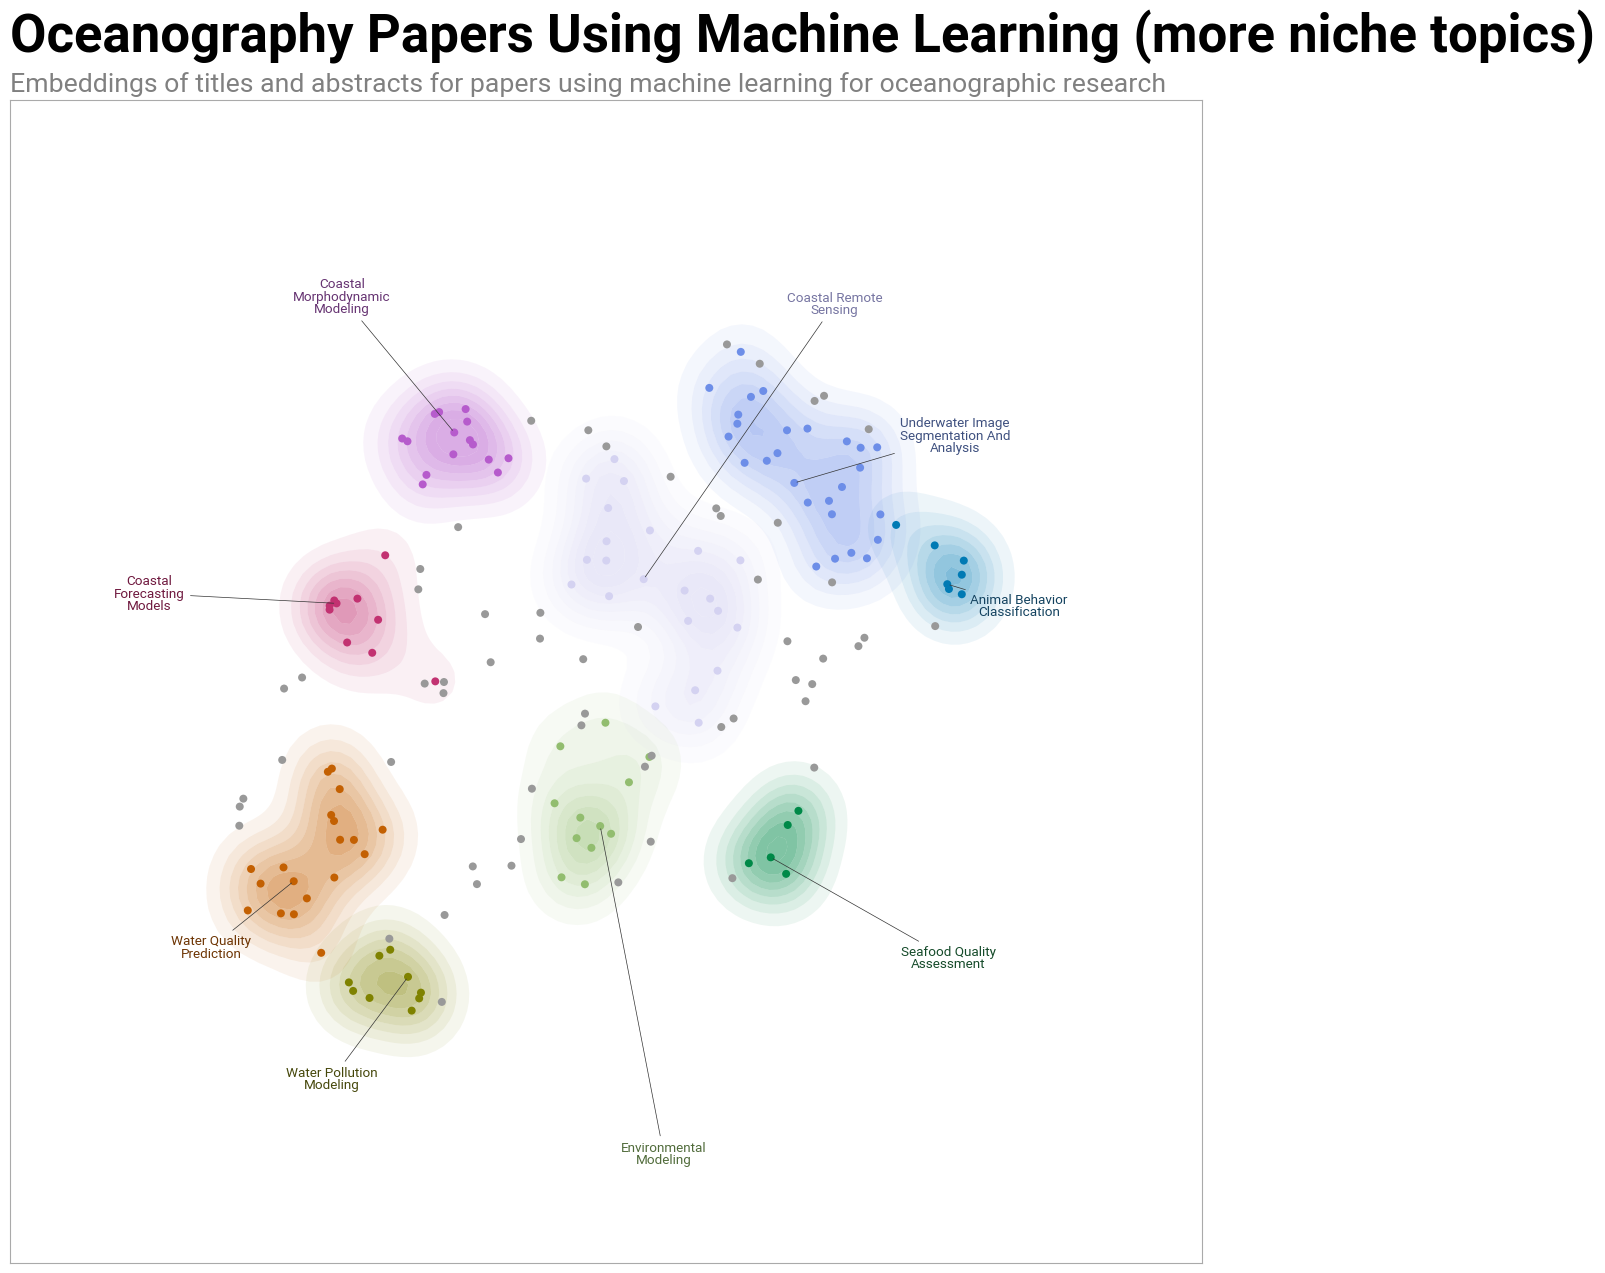

In [69]:
# Static visualization
fig, ax = datamapplot.create_plot(
    data_map,
    layer_clusters[0],
    title="Oceanography Papers Using Machine Learning (more niche topics)",
    sub_title="Embeddings of titles and abstracts for papers using machine learning for oceanographic research",
    darkmode=False,
    use_medoids=True,
    # label_font_size=11,
    # label_wrap_width=10,
)

In [70]:
fig.savefig("oceanography-ml-landscape-outliers.png", bbox_inches="tight")

# Export XLSX

In [78]:
clusters_df = pd.DataFrame(dataset[["Title", "Abstract"]])
clusters_df['embedding_alpha'] = data_map[:,0]
clusters_df['embedding_beta'] = data_map[:,1]
# clusters_df['embedding_full'] = list(map(str, data_vectors))
clusters_df

,Title,Abstract,embedding_alpha,embedding_beta
0,2023 5th International Conference on Environme...,The proceedings contain 118 papers. The topics...,13.810063,2.893558
6,A Biologist’s Guide to the Galaxy: Leveraging ...,Monitoring marine mammals is of broad interest...,17.611061,5.848142
16,"A Global, Cross-System Meta-Analysis of Polych...",Studies evaluating the mechanisms underpinning...,15.816220,3.474177
22,A Novel Framework to Predict Relative Habitat ...,Resource selection functions (RSFs) have been ...,17.236055,5.382223
25,A Reproducible and Reusable Pipeline for Segme...,Segmentation of Earth science imagery is an in...,16.929811,7.316052
...,...,...,...,...
871,Variability of Pacific herring (Clupea pallasi...,Pacific herring (Clupea pallasii) is an ecolog...,15.905581,4.266240
872,Verification of the skill of numerical weather...,The goal of this study is the evaluation of th...,13.431248,5.704895
873,Versatile in silico modeling of partition coef...,"Environmental fate, behavior and effects of ha...",14.081498,2.459354
881,Wave field predictions using a multi-layer per...,"In this study, a novel data-driven model is pr...",13.450677,5.682041


In [79]:
clusters_df["Topic"] = layer_clusters[0]
clusters_df["MetaTopic"] = layer_clusters[1]
# clusters_df["MetaMetaTopic"] = layer_clusters[2]

clusters_df.sort_values(["MetaTopic", "Topic"], inplace=True)

clusters_df

,Title,Abstract,embedding_alpha,embedding_beta,Topic,MetaTopic
159,Augmenting biologging with supervised machine ...,Zooplankton play critical roles in marine ecos...,18.592012,5.795503,Animal Behavior Classification,Image Classification
206,Characterizing the suckling behavior by video ...,Getting maternal milk through nursing is vital...,18.700090,5.908752,Animal Behavior Classification,Image Classification
221,Clustering and classification of vertical move...,Vertical movements can expose individuals to r...,18.700014,5.753957,Animal Behavior Classification,Image Classification
242,Computer-vision object tracking for monitoring...,This research presents a framework to enable c...,18.716829,6.020339,Animal Behavior Classification,Image Classification
287,Deep-Learning-Assisted Underwater 3D Tactile T...,The growth of underwater robotic applications ...,18.148746,6.302712,Animal Behavior Classification,Image Classification
...,...,...,...,...,...,...
697,Reconstructing input for artificial neural net...,Soil pore water salinity plays an important ro...,13.596426,3.810230,Water Quality Prediction,Water Quality Modeling
723,Review of machine learning-based surrogate mod...,Heavy computational load inhibits the applicat...,13.431902,3.512517,Water Quality Prediction,Water Quality Modeling
827,The use of hybrid machine learning models for ...,The objective of this study was to improve the...,13.377695,4.349327,Water Quality Prediction,Water Quality Modeling
833,Toward automating post processing of aquatic s...,Sensors measuring environmental phenomena at h...,12.732667,3.579932,Water Quality Prediction,Water Quality Modeling


Cleanup and add in the manual labels

In [80]:
clusters_df.to_excel("Topic_Results_Outliers.xlsx", index=False)